In [118]:
import numpy as np
import pandas as pd

import joblib

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder


import tensorflow as tf

from keras.utils import to_categorical

from keras.models import Model, load_model

from keras.layers import Dense, Input, Dropout

from keras.losses import categorical_crossentropy

from keras.activations import softmax, relu

from keras.optimizers import Nadam

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [38]:
tf.__version__

'2.10.1'

In [39]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print(f"GPUs disponíveis: {gpus}")
else:
    print("Nenhuma GPU encontrada.")

GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [40]:
pd.set_option("display.max_columns", None)

In [41]:
df = pd.read_csv("./data/dataset.csv")
print(df.shape)

(119390, 32)


In [42]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [43]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [44]:
# dados que estão como string
df_object = df.select_dtypes("object")

df_object.head()

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date
0,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Check-Out,2015-07-01
1,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Check-Out,2015-07-01
2,Resort Hotel,July,BB,GBR,Direct,Direct,A,C,No Deposit,Transient,Check-Out,2015-07-02
3,Resort Hotel,July,BB,GBR,Corporate,Corporate,A,A,No Deposit,Transient,Check-Out,2015-07-02
4,Resort Hotel,July,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2015-07-03


In [45]:
# número de valores unicos

df_object.nunique().reset_index().rename({"index": "colunas", 0: "valores"}, axis=1)

,colunas,valores
0,hotel,2
1,arrival_date_month,12
2,meal,5
3,country,177
4,market_segment,8
5,distribution_channel,5
6,reserved_room_type,10
7,assigned_room_type,12
8,deposit_type,3
9,customer_type,4


In [46]:
df["arrival_date_month"].value_counts()

arrival_date_month
August       13877
July         12661
May          11791
October      11160
April        11089
June         10939
September    10508
March         9794
February      8068
November      6794
December      6780
January       5929
Name: count, dtype: int64

Agosto tem o maior numero de reservas

### Preparação dos dados

In [47]:
# verificando colunas com valores ausentes

df_ctg_nas = df.isna().sum().reset_index().rename({0: "count"}, axis=1)
df_ctg_nas["percent"] = df_ctg_nas["count"] / df.shape[0] * 100
df_ctg_nas[df_ctg_nas["count"] > 0]

,index,count,percent
10,children,4,0.003350
13,country,488,0.408744
23,agent,16340,13.686238
24,company,112593,94.306893


In [48]:
# removendo a coluna company, pois tem muitos valores ausentes
# como podemos verificar acima 94% dos dados temos poucos valores ausentes

df.drop(columns=["company", "country"], inplace=True)

In [49]:
# remover os registros com valores ausentes
df.dropna(subset=["children"], inplace=True)

In [50]:
imputer = SimpleImputer(strategy="most_frequent")
df["agent"] = imputer.fit_transform(df[["agent"]])

In [51]:
# verificando se os valores ausentes foram removidos

df_ctg_nas = df.isna().sum().reset_index().rename({0: "count"}, axis=1)
df_ctg_nas["percent"] = df_ctg_nas["count"] / df.shape[0] * 100
df_ctg_nas[df_ctg_nas["count"] > 0]

,index,count,percent


In [52]:
# trabalhando com as variaveis categoricas

In [53]:
df.reset_index(inplace=True, drop=True)

In [54]:
mapeamento_meses = {
    "January": 1,
    "February": 2,
    "March": 3,
    "April": 4,
    "May": 5,
    "June": 6,
    "July": 7,
    "August": 8,
    "September": 9,
    "October": 10,
    "November": 11,
    "December": 12,
}

df["arrival_date_month"] = df["arrival_date_month"].map(mapeamento_meses)

In [55]:
hotel_ohe = OneHotEncoder(sparse_output=False)
df["hotel"] = hotel_ohe.fit_transform(df[["hotel"]])

In [56]:
meal_ohe = OneHotEncoder(sparse_output=True)
meal_encoded = meal_ohe.fit_transform(df[["meal"]])

meal_encoded_df = pd.DataFrame(
    meal_encoded.toarray(), columns=meal_ohe.get_feature_names_out()
)

df = pd.concat([df, meal_encoded_df], axis=1).drop(columns=["meal"])

In [57]:
market_ohe = OneHotEncoder(sparse_output=True)
market_encoded = market_ohe.fit_transform(df[["market_segment"]])

market_encoded_df = pd.DataFrame(
    market_encoded.toarray(), columns=market_ohe.get_feature_names_out()
)

df = pd.concat([df, market_encoded_df], axis=1).drop(columns=["market_segment"])

In [58]:
distribution_ohe = OneHotEncoder(sparse_output=True)
distribution_encoded = distribution_ohe.fit_transform(df[["distribution_channel"]])

distribution_encoded_df = pd.DataFrame(
    distribution_encoded.toarray(), columns=distribution_ohe.get_feature_names_out()
)

df = pd.concat([df, distribution_encoded_df], axis=1).drop(
    columns=["distribution_channel"]
)

In [59]:
df["reserved_room_type"].unique()

array(['C', 'A', 'D', 'E', 'G', 'F', 'H', 'L', 'P', 'B'], dtype=object)

In [60]:
reserved_ord = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    categories=[
        ["P", "O", "M", "L", "K", "J", "I", "H", "G", "F", "E", "D", "C", "B", "A"],
    ],
)

df["reserved_room_type"] = reserved_ord.fit_transform(df[["reserved_room_type"]])

In [61]:
df["assigned_room_type"].unique()

array(['C', 'A', 'D', 'E', 'G', 'F', 'I', 'B', 'H', 'P', 'L', 'K'],
      dtype=object)

In [62]:
assigned_ord = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    categories=[
        ["P", "O", "M", "L", "K", "J", "I", "H", "G", "F", "E", "D", "C", "B", "A"],
    ],
)

df["assigned_room_type"] = reserved_ord.fit_transform(df[["assigned_room_type"]])

In [63]:
df["customer_type"].unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

In [64]:
customer_ord = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    categories=[
        ["Transient", "Group", "Transient-Party", "Contract"],
    ],
)

df["customer_type"] = customer_ord.fit_transform(df[["customer_type"]])

In [65]:
df["deposit_type"].unique()

array(['No Deposit', 'Refundable', 'Non Refund'], dtype=object)

In [66]:
deposit_ord = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    categories=[
        ["No Deposit", "Refundable", "Non Refund"],
    ],
)

df["deposit_type"] = deposit_ord.fit_transform(df[["deposit_type"]])

In [67]:
# removendo variavel de data e a varriavel de status da reserva pois ela vaza dados para o modelo
df.drop(["reservation_status_date", "reservation_status"], axis=1, inplace=True)

In [68]:
df.tail()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined
119381,1.0,0,23,2017,8,35,30,2,5,2,0.0,0,0,0,0,14.0,14.0,0,0.0,394.0,0,0.0,96.14,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
119382,1.0,0,102,2017,8,35,31,2,5,3,0.0,0,0,0,0,10.0,10.0,0,0.0,9.0,0,0.0,225.43,0,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
119383,1.0,0,34,2017,8,35,31,2,5,2,0.0,0,0,0,0,11.0,11.0,0,0.0,9.0,0,0.0,157.71,0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
119384,1.0,0,109,2017,8,35,31,2,5,2,0.0,0,0,0,0,14.0,14.0,0,0.0,89.0,0,0.0,104.40,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
119385,1.0,0,205,2017,8,35,29,2,7,2,0.0,0,0,0,0,14.0,14.0,0,0.0,9.0,0,0.0,151.20,0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [69]:
df.select_dtypes("object").columns

Index([], dtype='object')

### Pre-processamento

In [70]:
X = df.drop("is_canceled", axis=1)
y = df["is_canceled"]

y = to_categorical(y)

In [71]:
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y, test_size=0.2, random_state=420, shuffle=True
)

In [73]:
print(X_treino.shape)
print(X_teste.shape)
print(y_treino.shape)
print(y_teste.shape)

(95508, 41)
(23878, 41)
(95508, 2)
(23878, 2)


#### Pradronização de X

In [74]:
mm_scaler = MinMaxScaler()

X_treino = mm_scaler.fit_transform(X_treino)
X_teste = mm_scaler.transform(X_teste)

### Modelo

In [75]:
input = Input(shape=(X_treino.shape[1],))
x = Dense(units=200, activation=relu)(input)
x = Dropout(0.2)(x)
x = Dense(units=200, activation=relu)(x)
x = Dropout(0.2)(x)
x = Dense(units=200, activation=relu)(x)
x = Dropout(0.2)(x)
x = Dense(units=100, activation=relu)(x)
x = Dropout(0.1)(x)
output = Dense(units=y_treino.shape[1], activation=softmax)(x)
model = Model(input, output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 41)]              0         
                                                                 
 dense (Dense)               (None, 200)               8400      
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 dropout_2 (Dropout)         (None, 200)               0     

In [76]:
model.compile(
    optimizer=Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss=categorical_crossentropy,
    metrics=["accuracy"],
)

callabacks = [
    EarlyStopping(monitor="val_loss", patience=20),
    ReduceLROnPlateau(monitor="val_loss", patience=10),
]

In [77]:
history = model.fit(
    X_treino,
    y_treino,
    validation_data=(X_teste, y_teste),
    epochs=50,
    batch_size=32,
    callbacks=callabacks,
    verbose=1,
)

Epoch 1/50
2985/2985 [==============================] - 25s 8ms/step - loss: 0.4811 - accuracy: 0.7709 - val_loss: 0.4403 - val_accuracy: 0.8025 - lr: 1.0000e-04
Epoch 2/50
2985/2985 [==============================] - 25s 8ms/step - loss: 0.4407 - accuracy: 0.7954 - val_loss: 0.4215 - val_accuracy: 0.8073 - lr: 1.0000e-04
Epoch 3/50
2985/2985 [==============================] - 25s 8ms/step - loss: 0.4263 - accuracy: 0.7996 - val_loss: 0.4146 - val_accuracy: 0.8060 - lr: 1.0000e-04
Epoch 4/50
2985/2985 [==============================] - 25s 9ms/step - loss: 0.4153 - accuracy: 0.8037 - val_loss: 0.4050 - val_accuracy: 0.8088 - lr: 1.0000e-04
Epoch 5/50
2985/2985 [==============================] - 25s 8ms/step - loss: 0.4075 - accuracy: 0.8083 - val_loss: 0.3986 - val_accuracy: 0.8122 - lr: 1.0000e-04
Epoch 6/50
2985/2985 [==============================] - 24s 8ms/step - loss: 0.4002 - accuracy: 0.8120 - val_loss: 0.3932 - val_accuracy: 0.8178 - lr: 1.0000e-04
Epoch 7/50
2985/2985 [======

In [78]:
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
accuracy = history_dict["accuracy"]
val_accuracy = history_dict["val_accuracy"]

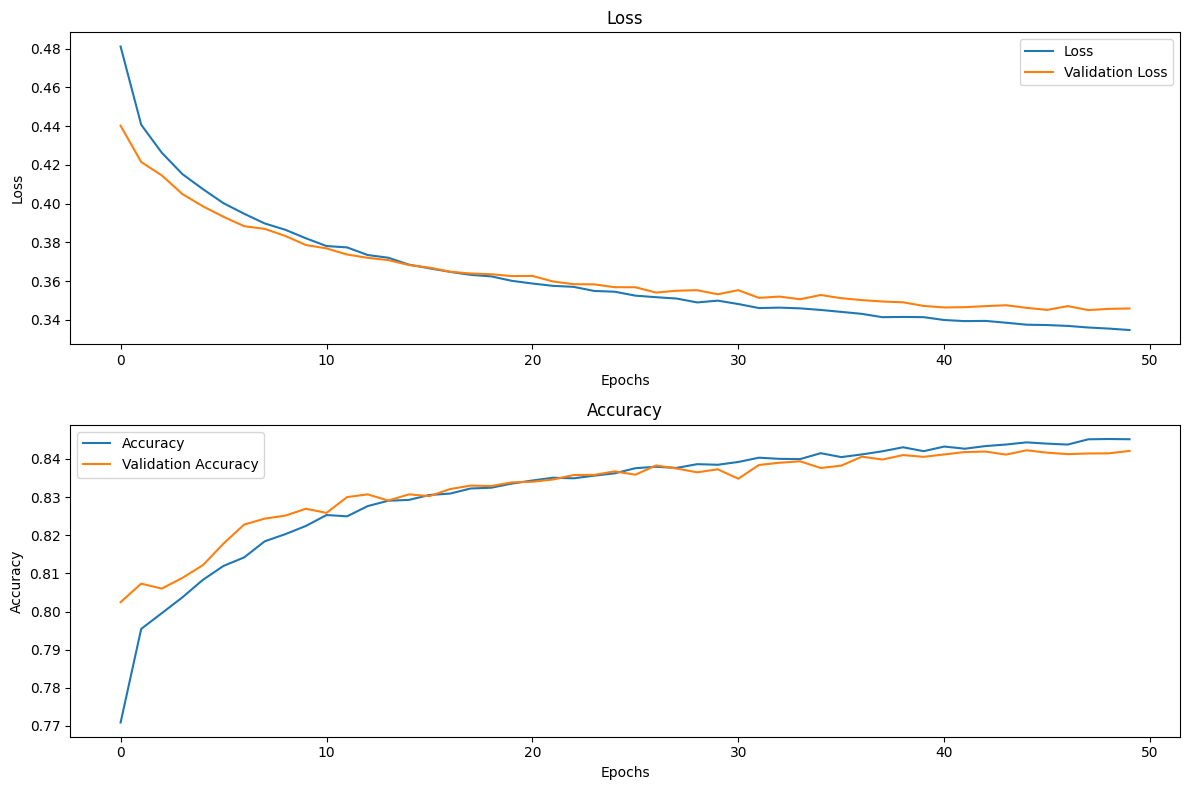

In [79]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(loss, label="Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(accuracy, label="Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [80]:
model.evaluate(X_teste, y_teste)

747/747 [==============================] - 2s 2ms/step - loss: 0.3459 - accuracy: 0.8421


[0.34590330719947815, 0.8421140909194946]

### Salvando os artefatos

In [81]:
joblib.dump(mm_scaler, "artifacts/scaler.pkl")
joblib.dump(deposit_ord, "artifacts/deposit_ord.pkl")
joblib.dump(meal_ohe, "artifacts/meal_ohe.pkl")
joblib.dump(hotel_ohe, "artifacts/hotel_ohe.pkl")
joblib.dump(distribution_ohe, "artifacts/distribution_ohe.pkl")
joblib.dump(reserved_ord, "artifacts/reserved_ord.pkl")
joblib.dump(customer_ord, "artifacts/customer_ord.pkl")
joblib.dump(mapeamento_meses, "artifacts/mapeamento_meses.pkl")
joblib.dump(market_ohe, "artifacts/market_ohe.pkl")
joblib.dump(assigned_ord, "artifacts/assigned_ord.pkl")

['artifacts/assigned_ord.pkl']

In [82]:
model.save("artifacts/model_1.h5")

### Deploy

In [112]:
novos_dados = {
    "hotel": [0.0],
    "lead_time": [23],
    "arrival_date_year": [2016],
    "arrival_date_month": [9],
    "arrival_date_week_number": [40],
    "arrival_date_day_of_month": [28],
    "stays_in_weekend_nights": [0],
    "stays_in_week_nights": [1],
    "adults": [1],
    "children": [0.0],
    "babies": [0],
    "is_repeated_guest": [1],
    "previous_cancellations": [3],
    "previous_bookings_not_canceled": [2],
    "reserved_room_type": [14.0],
    "assigned_room_type": [4.0],
    "booking_changes": [0],
    "deposit_type": [0.0],
    "agent": [9.0],
    "days_in_waiting_list": [0],
    "customer_type": [0.0],
    "adr": [89.1],
    "required_car_parking_spaces": [0],
    "total_of_special_requests": [0],
    "meal_BB": [1.0],
    "meal_FB": [0.0],
    "meal_HB": [0.0],
    "meal_SC": [0.0],
    "meal_Undefined": [0.0],
    "market_segment_Aviation": [0.0],
    "market_segment_Complementary": [0.0],
    "market_segment_Corporate": [1.0],
    "market_segment_Direct": [0.0],
    "market_segment_Groups": [0.0],
    "market_segment_Offline TA/TO": [0.0],
    "market_segment_Online TA": [0.0],
    "distribution_channel_Corporate": [1.0],
    "distribution_channel_Direct": [0.0],
    "distribution_channel_GDS": [0.0],
    "distribution_channel_TA/TO": [0.0],
    "distribution_channel_Undefined": [0.0],
}

In [84]:
model = load_model("artifacts/model_1.h5")
mm_scaler = joblib.load("artifacts/scaler.pkl")

In [113]:
novos_dados_df = pd.DataFrame(novos_dados)
novos_dados_df

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined
0,0.0,23,2016,9,40,28,0,1,1,0.0,0,1,3,2,14.0,4.0,0,0.0,9.0,0,0.0,89.1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [122]:
prediction = model.predict(mm_scaler.transform(novos_dados_df))
print(prediction)

"cancelado" if np.argmax(prediction) else "não cancelado"

1/1 [==============================] - 0s 19ms/step
[[0.05432098 0.945679  ]]


'cancelado'